<a href="https://colab.research.google.com/github/Nuri-Tas/Time-Series/blob/main/Technical%20Analysis/TSA/Moving%20Average%20and%20MARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import simplefilter
simplefilter('ignore')

%matplotlib inline

In [2]:
plt.style.use('seaborn-whitegrid')

plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 5),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)


Import tunnel dataset:

In [4]:
tunnel = pd.read_csv('/content/tunnel.csv', index_col='Day', parse_dates=True)
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Plot 365-day rolling average and set min_periods to be about half the window size.

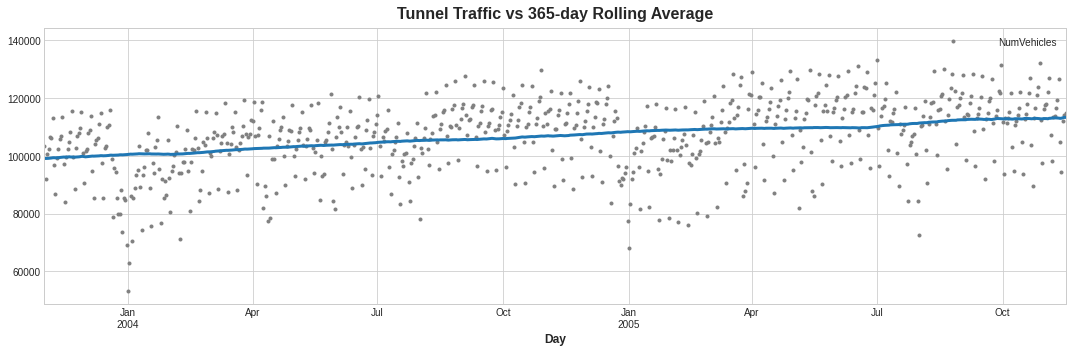

In [5]:
roll_mean = tunnel.NumVehicles.rolling(window=365,
                          center=True,
                           min_periods=183
                          ).mean()

ax = tunnel.plot(style='.', color='0.5')
ax = roll_mean.plot(label='365-day Rolling Average', linewidth=3, title='Tunnel Traffic vs 365-day Rolling Average')

Create time dummy variables with DeterministicProcess:

In [6]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=tunnel.index,
                     order=1,
                     constant=True,
                     drop=True)
X = dp.in_sample()
X

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0
...,...,...
2005-11-12,1.0,743.0
2005-11-13,1.0,744.0
2005-11-14,1.0,745.0


Build the linear regression model. Note that we set `fit_intercept` parameter False in linear regression as X already has intercept variables coming from `constant` parameters. 

In [7]:
from sklearn.linear_model import LinearRegression

y = tunnel.NumVehicles

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

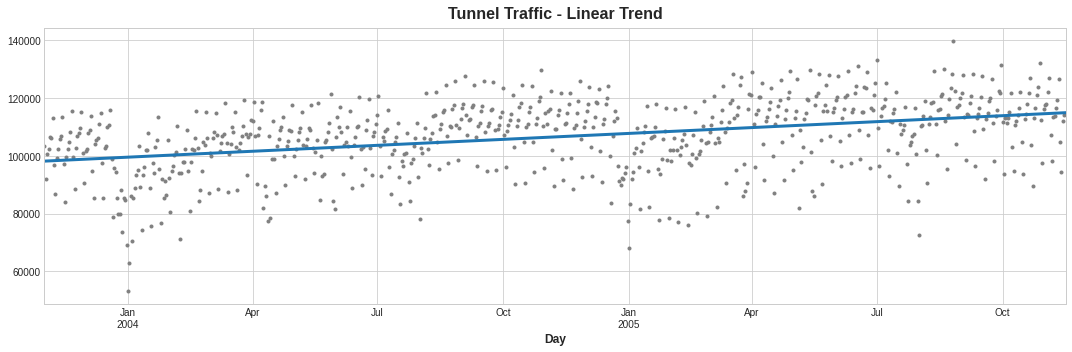

In [8]:
ax = y.plot(style='.', color='.5')
pd.Series(model.predict(X), index=X.index).plot(ax=ax, linewidth=3, title='Tunnel Traffic - Linear Trend')

Forecast the tunnel traffic for the next 15 days outside of the training data:

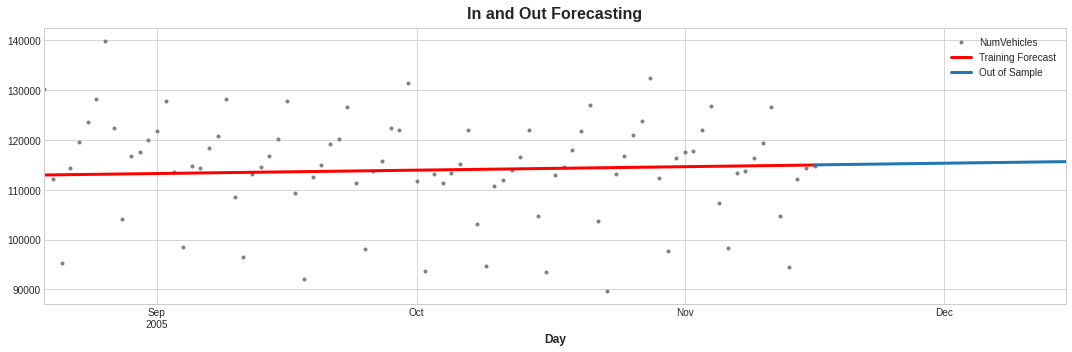

In [9]:
X_future = dp.out_of_sample(steps=30, forecast_index=[X.index[-1] + pd.Timedelta(days=i) for i in range(0,30)])


ax = y.iloc[-90:].plot(style='.', color='.5')
pd.Series(model.predict(X), index=X.index).iloc[-90:].plot(ax=ax, linewidth=3, color='r', label='Training Forecast')
y_pred = pd.Series(model.predict(X_future), index=X_future.index).plot(ax=ax, linewidth=3, label='Out of Sample',  title='In and Out Forecasting')

ax.legend()

### Fit Trends with Splines 


Build splines with MARS to forecast out of sample values:

In [14]:
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-learn-contrib/py-earth (to revision v0.2dev) to /tmp/pip-req-build-oe0lbsqh
  Running command git clone -q https://github.com/scikit-learn-contrib/py-earth /tmp/pip-req-build-oe0lbsqh
  Running command git checkout -b v0.2dev --track origin/v0.2dev
  Switched to a new branch 'v0.2dev'
  Branch 'v0.2dev' set up to track remote branch 'v0.2dev' from 'origin'.
  Created wheel for sklearn-contrib-py-earth: filename=sklearn_contrib_py_earth-0.1.0+16.g400f84d-cp37-cp37m-linux_x86_64.whl size=3997234 sha256=87a0c0bcbb5446df2045013098a3e3e200f2b617a42d7c406b0c423533f719c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-11indpgr/wheels/79/d7/aa/1e418a9aea84424ef2ce2697ae7cccace322976388d3692e8e
Successfully built sklearn-contrib-py-earth


In [17]:
from pyearth import Earth

model = Earth()
model.fit(X, y)

Earth()

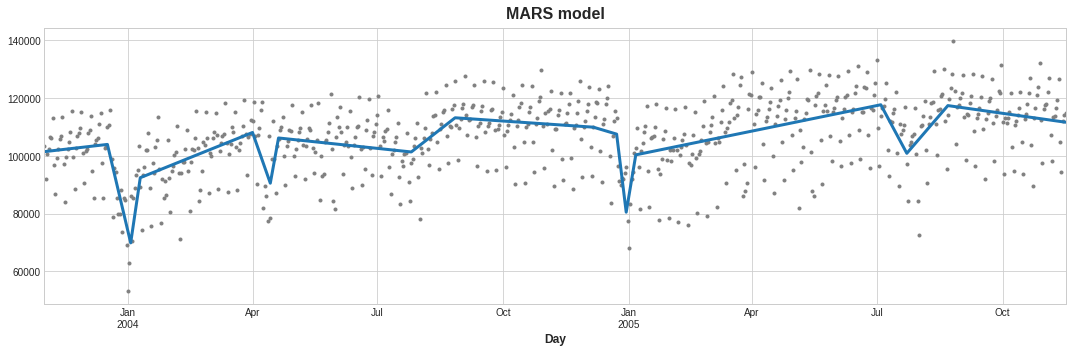

In [24]:
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(style='.', color='0.5')
y_pred.plot(linewidth=3,title ='MARS model', ax=ax, label='Trend')

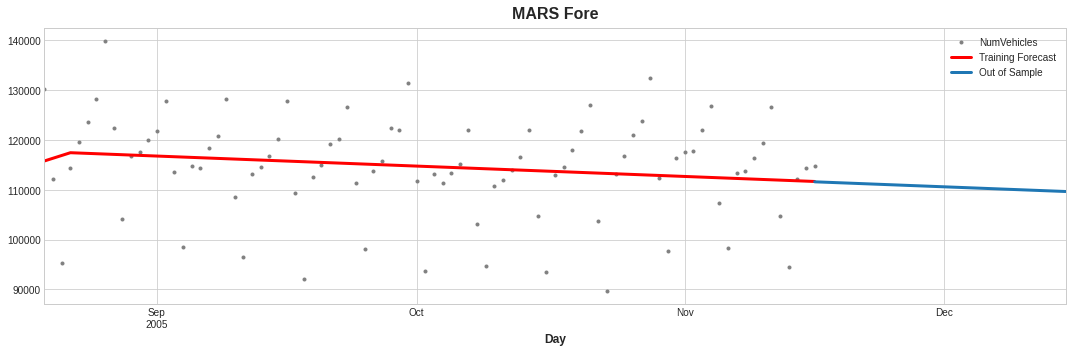

In [30]:
ax = y.iloc[-90:].plot(style='.', color='.5')
pd.Series(model.predict(X), index=X.index).iloc[-90:].plot(ax=ax, linewidth=3, color='r', label='Training Forecast')
y_pred = pd.Series(model.predict(X_future), index=X_future.index).plot(ax=ax, linewidth=3, label='Out of Sample',  title='MARS Fore')

ax.legend()